# U-Net CNN Model for Ancient Wall Segmentation (4 Classes) - Orthomosaics Only
## Classes:
- 0: Background (Black)
- 1: Ashlar (Blue)
- 2: Quarry (Yellow)
- 3: Polygonal (Red)


# (1) Python import section

In [1]:
# Import required modules
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Setup device
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    print("No GPU available, using CPU")
    device = torch.device('cpu')

# Enable TF32 for better performance
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

PyTorch version: 2.9.0.dev20250721+cu128
CUDA available: True
CUDA version: 12.8
GPU: NVIDIA GeForce RTX 5080


C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\backends\__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:83.)
  self.setter(val)


# (2) Specify the parameters

In [2]:
# Define classes
CLASS_NAMES = ['Background', 'Ashlar', 'Polygonal', 'Quarry']
CLASS_COLORS = ['black', 'blue', 'red', 'yellow']
NUM_CLASSES = 4

# Data directories - Mac
#rgbaDirectory = "/Users/nilsschnorr/Desktop/2025-03-12_Trainingsdaten/1280_images"
#maskDirectory = "/Users/nilsschnorr/Desktop/2025-03-12_Trainingsdaten/1280_masks"

# Data directories - Windows
rgbaDirectory = "C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/snippets_orthomosaics"
maskDirectory = "C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/snippets_masks"

# Model parameters
modelTrainedName = "2025-08-11_4-channel_4-class-EX"
modelTrainedExt = "pth"
numEpochs = 300
debugModus = True

modelTrainedName = modelTrainedName + "_" + str(numEpochs) + "." + modelTrainedExt

print('=== 4-Class Segmentation Model (Orthomosaics Only) ===')
print('Classes:', CLASS_NAMES)
print('Model name:', modelTrainedName)
print('Number of epochs:', numEpochs)
print('Input channels: 4 (RGBA)')

=== 4-Class Segmentation Model (Orthomosaics Only) ===
Classes: ['Background', 'Ashlar', 'Polygonal', 'Quarry']
Model name: 2025-08-11_4-channel_4-class-EX_300.pth
Number of epochs: 300
Input channels: 4 (RGBA)


# (3) Define the U-Net Model

In [3]:
class DoubleConv(nn.Module):
    """Double convolution block"""
    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.relu2(x)
        return x

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, dropout_rate)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling with bilinear interpolation"""
    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv_after_up = nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1)
        self.conv = DoubleConv(in_channels, out_channels, dropout_rate)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.conv_after_up(x1)
        
        # Handle size mismatch
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        if diffX != 0 or diffY != 0:
            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class MultiUNet(nn.Module):
    def __init__(self, n_channels=4, n_classes=4):
        super(MultiUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder
        self.inc = DoubleConv(n_channels, 16, 0.1)
        self.down1 = Down(16, 32, 0.1)
        self.down2 = Down(32, 64, 0.2)
        self.down3 = Down(64, 128, 0.2)
        self.down4 = Down(128, 256, 0.3)
        
        # Decoder
        self.up1 = Up(256, 128, 0.2)
        self.up2 = Up(128, 64, 0.2)
        self.up3 = Up(64, 32, 0.1)
        self.up4 = Up(32, 16, 0.1)
        self.outc = nn.Conv2d(16, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

def initialize_weights(model):
    """Initialize model weights"""
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

# (4) Load the input images and masks

In [4]:
# Define image size
SIZE_X, SIZE_Y = 512, 512

# Get sorted lists of files
rgba_paths = sorted(glob.glob(os.path.join(rgbaDirectory, "*.png")))

# Load training images (RGBA only)
train_images = []
for i, rgba_path in enumerate(rgba_paths):
    # Load RGBA image
    img_rgba = cv2.imread(rgba_path, cv2.IMREAD_UNCHANGED)
    if img_rgba is None or img_rgba.shape[-1] != 4:
        print(f"Error loading RGBA image: {rgba_path}")
        continue
    img_rgba = cv2.resize(img_rgba, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_AREA)
    
    train_images.append(img_rgba)
    print(f"{i}: {rgba_path}")

train_images = np.array(train_images)
print(f'\nTrain images shape: {train_images.shape}')

# Load masks
train_masks = []
mask_paths = sorted(glob.glob(os.path.join(maskDirectory, "*.png")))
for i, mask_path in enumerate(mask_paths):
    mask = cv2.imread(mask_path, 0)
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
    train_masks.append(mask)
    print(f"{i}: {mask_path}")

train_masks = np.array(train_masks)
print(f'\nTrain masks shape: {train_masks.shape}')
print(f'Unique mask values: {np.unique(train_masks)}')

0: C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/snippets_orthomosaics\00000001_H_Bf_1-4_png-ortho.png
1: C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/snippets_orthomosaics\00000004_H_Bf_1-4_png-ortho.png
2: C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/snippets_orthomosaics\00000005_H_Bf_1-4_png-ortho.png
3: C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/snippets_orthomosaics\00000008_H_Bf_1-4_png-ortho.png
4: C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/snippets_orthomosaics\00000009_H_Bf_1-4_png-ortho.png
5: C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/snippets_orthomosaics\00000011_H_Bf_1-4_png-ortho.png
6: C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/snippets_orthomosaics\00000024_H_Bf_1-4_png-ortho.png
7: C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/snippets_orthomosaics\00000025_H_Bf_1-4_png-ortho.png
8: C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/snippets_orthomosaics\00000028_H_Bf_1

# (5) Prepare the data for training

In [5]:
# Encode labels
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

# Normalize images
train_images = train_images.astype('float32') / 255.0
train_masks_input = train_masks_encoded_original_shape

# Split data: 90% train, 10% validation
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_masks_input, 
    test_size=0.1,  # 10% for validation
    random_state=0
)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Classes in dataset: {np.unique(y_train)}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).permute(0, 3, 1, 2)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val).permute(0, 3, 1, 2)
y_val_tensor = torch.LongTensor(y_val)

# Calculate class weights
class_labels = np.unique(train_masks_reshaped_encoded)
class_weights_balanced = compute_class_weight('balanced', classes=class_labels, y=train_masks_reshaped_encoded)

# Use equal weights (set to False for balanced weights)
USE_EQUAL_WEIGHTS = True

if USE_EQUAL_WEIGHTS:
    print("\nUsing EQUAL class weights")
    class_weights = np.ones(NUM_CLASSES)
    class_weights_tensor = None
else:
    print("\nUsing BALANCED class weights")
    class_weights = class_weights_balanced
    class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print("\nClass weights:")
for i, weight in enumerate(class_weights):
    print(f"Class {i} ({CLASS_NAMES[i]}): {weight:.4f}")

Training set: 1934 images
Validation set: 215 images
Classes in dataset: [0 1 2 3]

Using EQUAL class weights

Class weights:
Class 0 (Background): 1.0000
Class 1 (Ashlar): 1.0000
Class 2 (Polygonal): 1.0000
Class 3 (Quarry): 1.0000


# (6) Compile the model

In [6]:
# Model configuration
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
n_classes = NUM_CLASSES

print(f"Model input: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f"Output classes: {n_classes}")

# Create model
model = MultiUNet(n_channels=IMG_CHANNELS, n_classes=n_classes).to(device)
initialize_weights(model)

# Loss function
class CEDiceLoss(nn.Module):
    def __init__(self, weight=None, smooth=1e-5):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weight)
        self.smooth = smooth
        
    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        
        # Dice loss
        inputs_soft = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0,3,1,2).float()
        
        dims = (2, 3)
        intersection = (inputs_soft * targets_one_hot).sum(dims)
        cardinality = inputs_soft.sum(dims) + targets_one_hot.sum(dims)
        dice_score = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        dice_loss = 1. - dice_score.mean()
        
        return 0.5 * ce_loss + 0.5 * dice_loss

criterion = CEDiceLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-7)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

# IoU metric
def calculate_iou(predictions, labels, n_classes):
    ious = []
    predictions = torch.argmax(predictions, dim=1)
    
    for cls in range(n_classes):
        pred_mask = (predictions == cls)
        true_mask = (labels == cls)
        
        intersection = (pred_mask & true_mask).float().sum()
        union = (pred_mask | true_mask).float().sum()
        
        if union == 0:
            iou = 1.0 if intersection == 0 else 0.0
        else:
            iou = intersection / union
        
        ious.append(iou.item() if isinstance(iou, torch.Tensor) else iou)
    
    return np.mean(ious)

Model input: 512x512x4
Output classes: 4

Total parameters: 2,158,900


# (7) Train and save the model

In [7]:
print(f'Starting training at: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Added shuffle=True for better training
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Training history
history = {
    'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [],
    'iou_metric': [], 'val_iou_metric': []
}

# Training loop
for epoch in range(numEpochs):
    # Training phase
    model.train()
    train_loss = train_correct = train_total = train_iou = 0.0
    
    data_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{numEpochs}') if epoch % 10 == 0 else train_loader
    
    for data, target in data_iterator:
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        train_total += target.numel()
        train_correct += (predicted == target).sum().item()
        
        with torch.no_grad():
            train_iou += calculate_iou(output, target, n_classes)

    # Validation phase
    model.eval()
    val_loss = val_correct = val_total = val_iou = 0.0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            val_total += target.numel()
            val_correct += (predicted == target).sum().item()
            val_iou += calculate_iou(output, target, n_classes)
    
    # Calculate metrics
    epoch_train_loss = train_loss / len(train_loader)
    epoch_val_loss = val_loss / len(val_loader)
    epoch_train_acc = train_correct / train_total
    epoch_val_acc = val_correct / val_total
    epoch_train_iou = train_iou / len(train_loader)
    epoch_val_iou = val_iou / len(val_loader)
    
    # Store history
    history['loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['accuracy'].append(epoch_train_acc)
    history['val_accuracy'].append(epoch_val_acc)
    history['iou_metric'].append(epoch_train_iou)
    history['val_iou_metric'].append(epoch_val_iou)
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'\nEpoch [{epoch+1}/{numEpochs}]')
        print(f'Loss: {epoch_train_loss:.4f} -> {epoch_val_loss:.4f}')
        print(f'Acc: {epoch_train_acc:.4f} -> {epoch_val_acc:.4f}')
        print(f'IoU: {epoch_train_iou:.4f} -> {epoch_val_iou:.4f}')

# Save model
torch.save({
    'epoch': numEpochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': epoch_train_loss,
    'history': history,
    'n_classes': n_classes,
    'class_names': CLASS_NAMES,
    'class_colors': CLASS_COLORS,
    'img_channels': IMG_CHANNELS
}, modelTrainedName)

print(f'\nTraining completed at: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
print(f'Final results - Loss: {history["val_loss"][-1]:.4f}, Acc: {history["val_accuracy"][-1]:.2%}, IoU: {history["val_iou_metric"][-1]:.4f}')

Starting training at: 2025-08-13 19:03:38


Epoch 1/300: 100%|██████████| 121/121 [00:27<00:00,  4.44it/s]



Epoch [10/300]
Loss: 0.6244 -> 0.5856
Acc: 0.7566 -> 0.7909
IoU: 0.3993 -> 0.4546


Epoch 11/300: 100%|██████████| 121/121 [00:19<00:00,  6.07it/s]



Epoch [20/300]
Loss: 0.5768 -> 0.5432
Acc: 0.7996 -> 0.8223
IoU: 0.4525 -> 0.4857


Epoch 21/300: 100%|██████████| 121/121 [00:19<00:00,  6.06it/s]



Epoch [30/300]
Loss: 0.5325 -> 0.5034
Acc: 0.8354 -> 0.8544
IoU: 0.4918 -> 0.5178


Epoch 31/300: 100%|██████████| 121/121 [00:19<00:00,  6.08it/s]



Epoch [40/300]
Loss: 0.4851 -> 0.4590
Acc: 0.8654 -> 0.8794
IoU: 0.5528 -> 0.5852


Epoch 41/300: 100%|██████████| 121/121 [00:19<00:00,  6.07it/s]



Epoch [50/300]
Loss: 0.4456 -> 0.4409
Acc: 0.8877 -> 0.8908
IoU: 0.6043 -> 0.6064


Epoch 51/300: 100%|██████████| 121/121 [00:19<00:00,  6.06it/s]



Epoch [60/300]
Loss: 0.4108 -> 0.4092
Acc: 0.9050 -> 0.9027
IoU: 0.6522 -> 0.6514


Epoch 61/300: 100%|██████████| 121/121 [00:19<00:00,  6.08it/s]



Epoch [70/300]
Loss: 0.3862 -> 0.3898
Acc: 0.9172 -> 0.9136
IoU: 0.6832 -> 0.6803


Epoch 71/300: 100%|██████████| 121/121 [00:19<00:00,  6.08it/s]



Epoch [80/300]
Loss: 0.3659 -> 0.3749
Acc: 0.9253 -> 0.9165
IoU: 0.7102 -> 0.7001


Epoch 81/300: 100%|██████████| 121/121 [00:19<00:00,  6.07it/s]



Epoch [90/300]
Loss: 0.3472 -> 0.3620
Acc: 0.9328 -> 0.9259
IoU: 0.7402 -> 0.7163


Epoch 91/300: 100%|██████████| 121/121 [00:19<00:00,  6.07it/s]



Epoch [100/300]
Loss: 0.3294 -> 0.3514
Acc: 0.9401 -> 0.9304
IoU: 0.7644 -> 0.7356


Epoch 101/300: 100%|██████████| 121/121 [00:19<00:00,  6.08it/s]



Epoch [110/300]
Loss: 0.3142 -> 0.3315
Acc: 0.9461 -> 0.9408
IoU: 0.7845 -> 0.7651


Epoch 111/300: 100%|██████████| 121/121 [00:19<00:00,  6.08it/s]



Epoch [120/300]
Loss: 0.3025 -> 0.3249
Acc: 0.9504 -> 0.9422
IoU: 0.7994 -> 0.7731


Epoch 121/300: 100%|██████████| 121/121 [00:19<00:00,  6.14it/s]



Epoch [130/300]
Loss: 0.2887 -> 0.3154
Acc: 0.9556 -> 0.9465
IoU: 0.8212 -> 0.7884


Epoch 131/300: 100%|██████████| 121/121 [00:19<00:00,  6.24it/s]



Epoch [140/300]
Loss: 0.2801 -> 0.3220
Acc: 0.9589 -> 0.9440
IoU: 0.8320 -> 0.7798


Epoch 141/300: 100%|██████████| 121/121 [00:19<00:00,  6.23it/s]



Epoch [150/300]
Loss: 0.2715 -> 0.3091
Acc: 0.9624 -> 0.9516
IoU: 0.8426 -> 0.8007


Epoch 151/300: 100%|██████████| 121/121 [00:19<00:00,  6.22it/s]



Epoch [160/300]
Loss: 0.2635 -> 0.3050
Acc: 0.9656 -> 0.9520
IoU: 0.8556 -> 0.8060


Epoch 161/300: 100%|██████████| 121/121 [00:19<00:00,  6.25it/s]



Epoch [170/300]
Loss: 0.2564 -> 0.3069
Acc: 0.9681 -> 0.9512
IoU: 0.8666 -> 0.7999


Epoch 171/300: 100%|██████████| 121/121 [00:19<00:00,  6.24it/s]



Epoch [180/300]
Loss: 0.2491 -> 0.3074
Acc: 0.9712 -> 0.9511
IoU: 0.8757 -> 0.8046


Epoch 181/300: 100%|██████████| 121/121 [00:19<00:00,  6.25it/s]



Epoch [190/300]
Loss: 0.2464 -> 0.2978
Acc: 0.9720 -> 0.9569
IoU: 0.8813 -> 0.8123


Epoch 191/300: 100%|██████████| 121/121 [00:19<00:00,  6.23it/s]



Epoch [200/300]
Loss: 0.2422 -> 0.3051
Acc: 0.9734 -> 0.9542
IoU: 0.8864 -> 0.8066


Epoch 201/300: 100%|██████████| 121/121 [00:19<00:00,  6.23it/s]



Epoch [210/300]
Loss: 0.2386 -> 0.2962
Acc: 0.9748 -> 0.9576
IoU: 0.8912 -> 0.8208


Epoch 211/300: 100%|██████████| 121/121 [00:19<00:00,  6.22it/s]



Epoch [220/300]
Loss: 0.2363 -> 0.2909
Acc: 0.9757 -> 0.9593
IoU: 0.8934 -> 0.8269


Epoch 221/300: 100%|██████████| 121/121 [00:19<00:00,  6.22it/s]



Epoch [230/300]
Loss: 0.2320 -> 0.3013
Acc: 0.9774 -> 0.9561
IoU: 0.8995 -> 0.8154


Epoch 231/300: 100%|██████████| 121/121 [00:19<00:00,  6.20it/s]



Epoch [240/300]
Loss: 0.2310 -> 0.3045
Acc: 0.9777 -> 0.9548
IoU: 0.9028 -> 0.8191


Epoch 241/300: 100%|██████████| 121/121 [00:19<00:00,  6.22it/s]



Epoch [250/300]
Loss: 0.2281 -> 0.2918
Acc: 0.9787 -> 0.9602
IoU: 0.9061 -> 0.8284


Epoch 251/300: 100%|██████████| 121/121 [00:19<00:00,  6.20it/s]



Epoch [260/300]
Loss: 0.2248 -> 0.2933
Acc: 0.9799 -> 0.9607
IoU: 0.9094 -> 0.8314


Epoch 261/300: 100%|██████████| 121/121 [00:19<00:00,  6.22it/s]



Epoch [270/300]
Loss: 0.2237 -> 0.2866
Acc: 0.9803 -> 0.9623
IoU: 0.9125 -> 0.8388


Epoch 271/300: 100%|██████████| 121/121 [00:19<00:00,  6.20it/s]



Epoch [280/300]
Loss: 0.2232 -> 0.2971
Acc: 0.9805 -> 0.9573
IoU: 0.9142 -> 0.8288


Epoch 281/300: 100%|██████████| 121/121 [00:19<00:00,  6.32it/s]



Epoch [290/300]
Loss: 0.2199 -> 0.2909
Acc: 0.9815 -> 0.9618
IoU: 0.9172 -> 0.8389


Epoch 291/300: 100%|██████████| 121/121 [00:19<00:00,  6.32it/s]



Epoch [300/300]
Loss: 0.2195 -> 0.2994
Acc: 0.9819 -> 0.9600
IoU: 0.9180 -> 0.8310

Training completed at: 2025-08-13 20:45:30
Final results - Loss: 0.2994, Acc: 96.00%, IoU: 0.8310


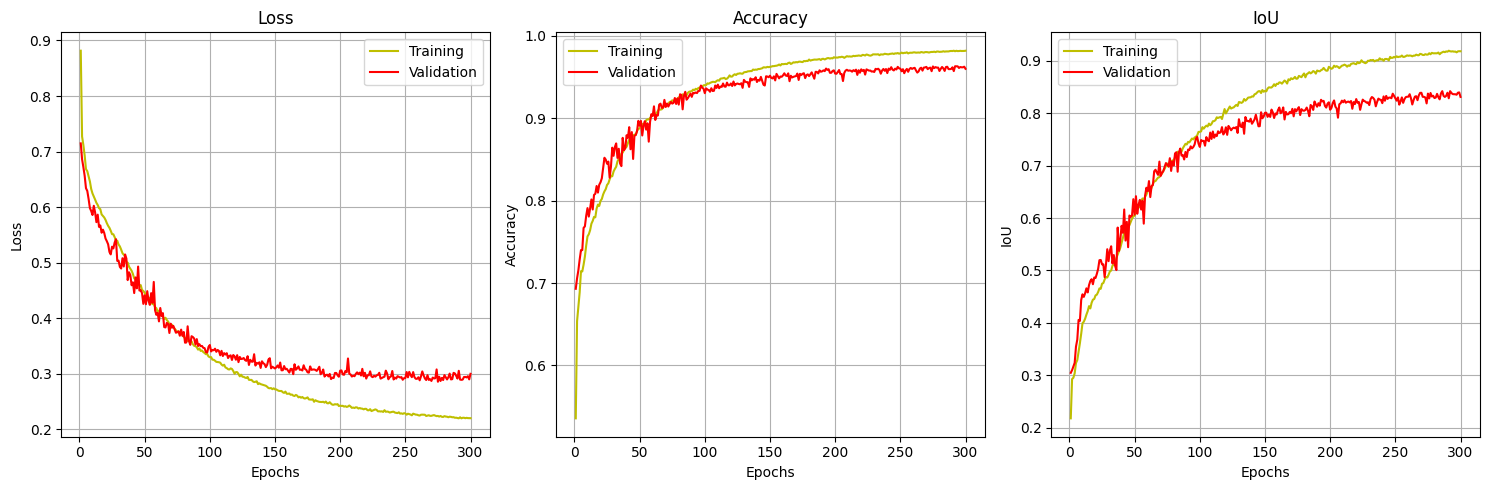

In [8]:
# Plot training history
epochs = range(1, len(history['loss']) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, history['loss'], 'y-', label='Training')
plt.plot(epochs, history['val_loss'], 'r-', label='Validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs, history['accuracy'], 'y-', label='Training')
plt.plot(epochs, history['val_accuracy'], 'r-', label='Validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs, history['iou_metric'], 'y-', label='Training')
plt.plot(epochs, history['val_iou_metric'], 'r-', label='Validation')
plt.title('IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# (8) Evaluate and visualize results

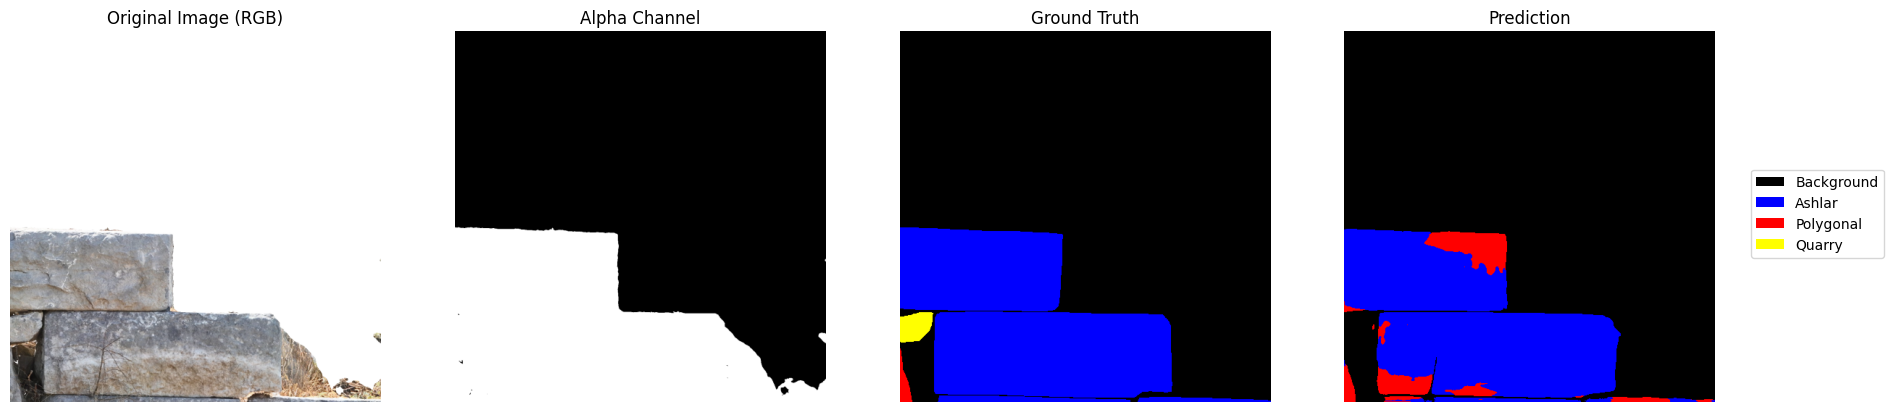

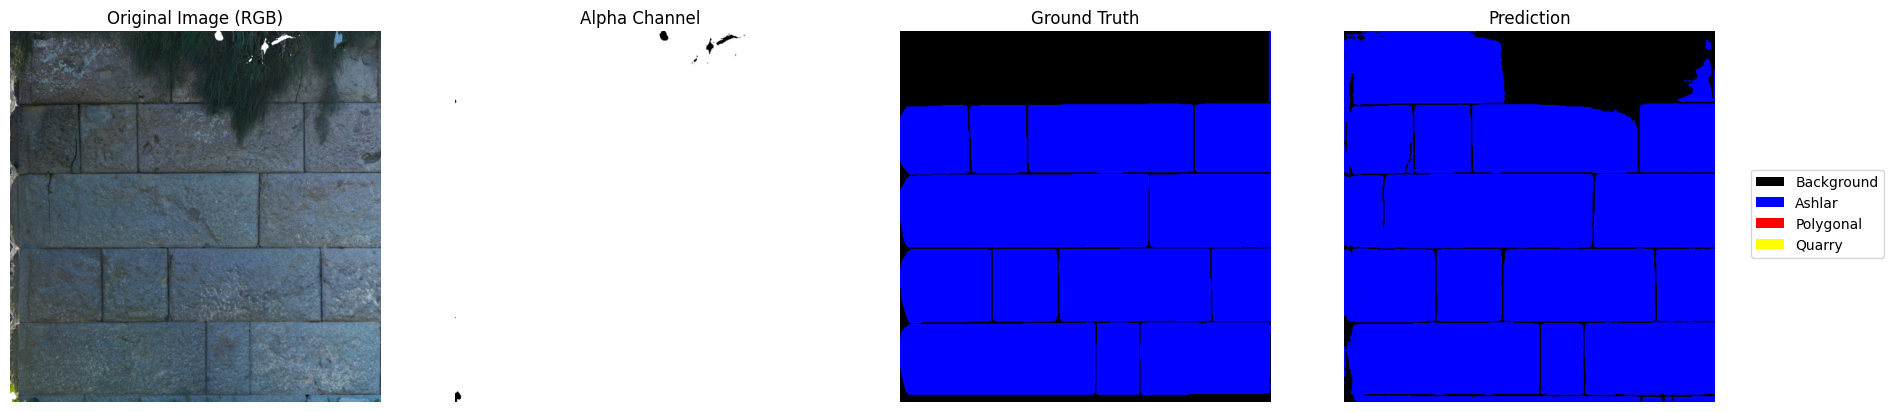

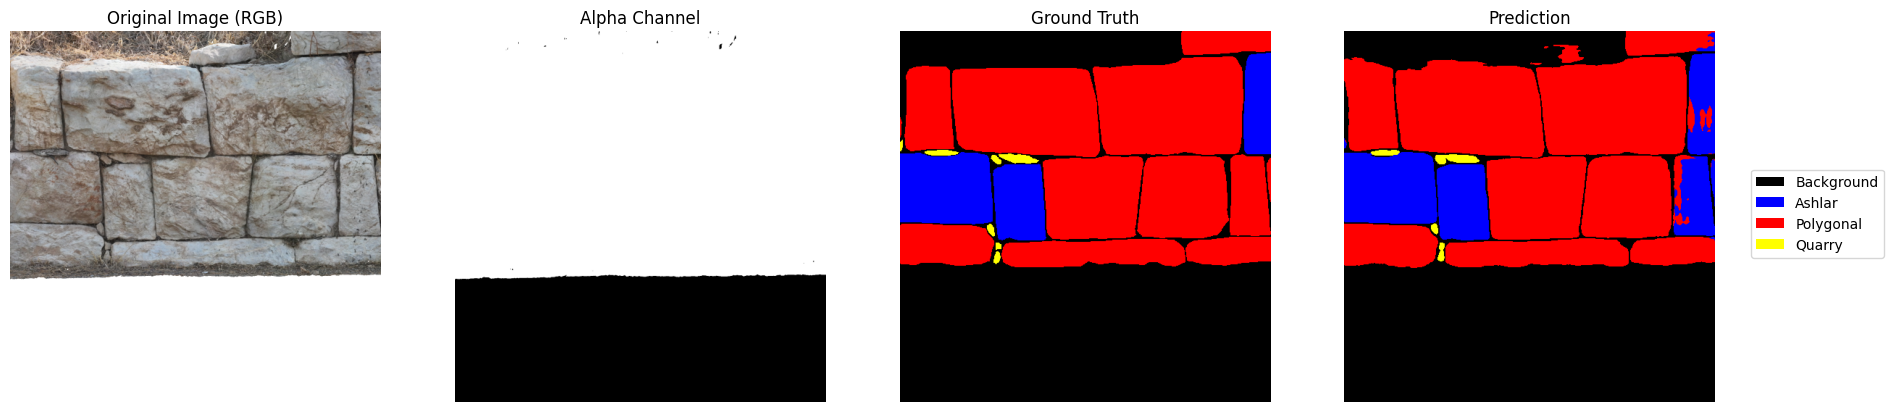

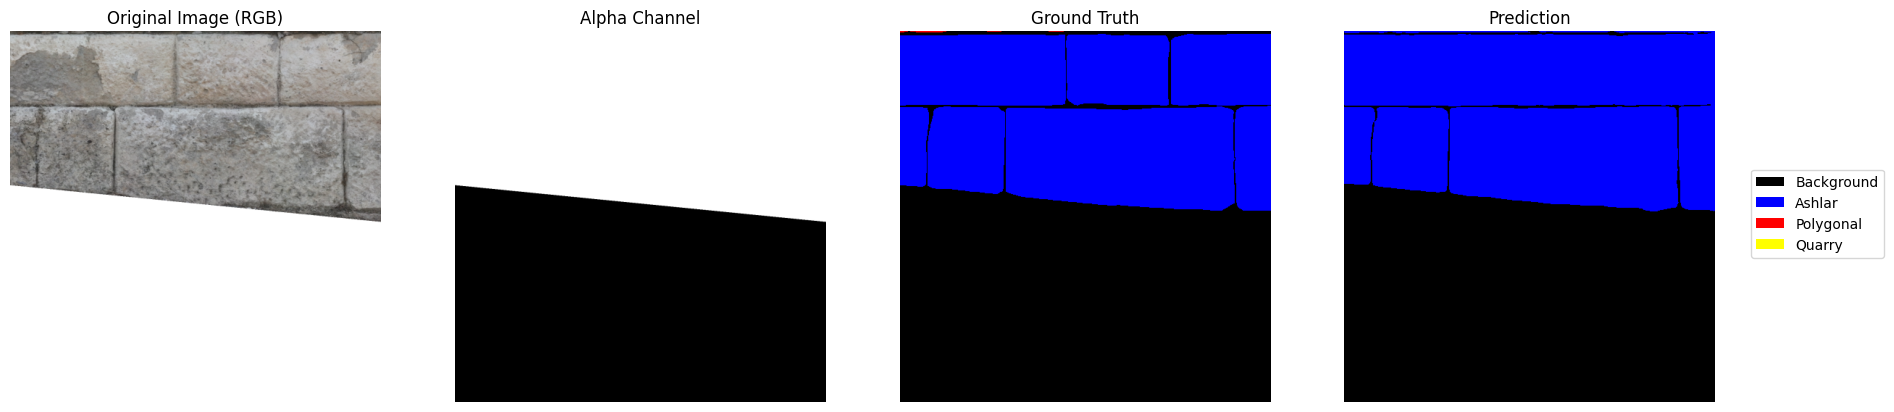

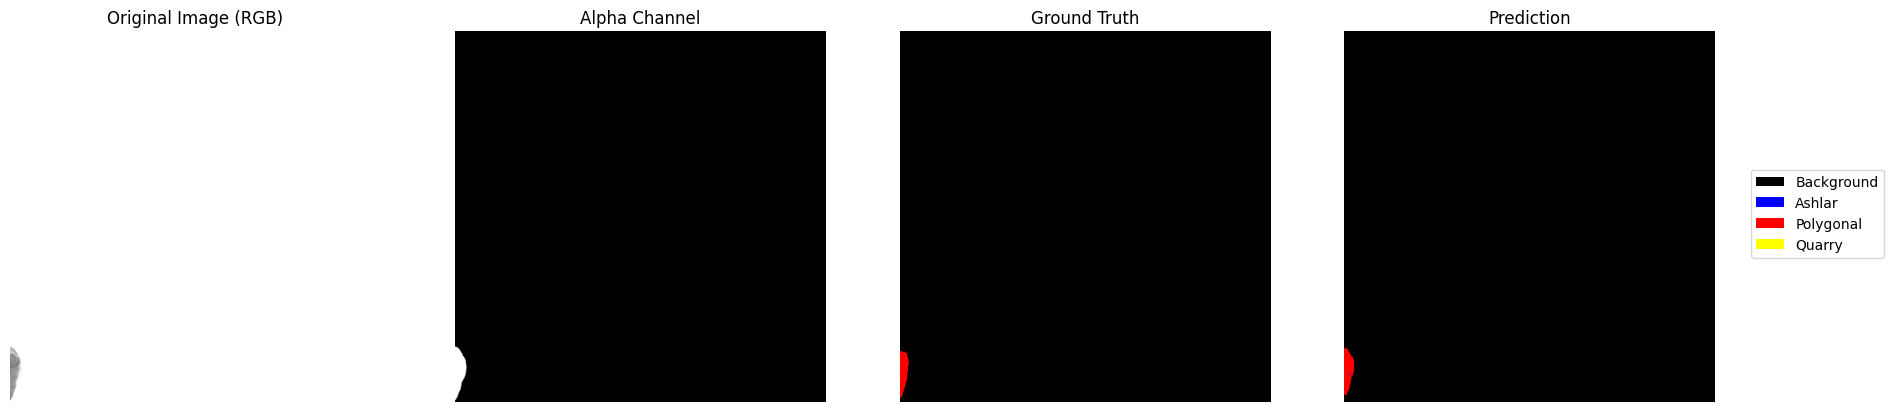

In [9]:
# Set up colormap
cmap_seg = ListedColormap(CLASS_COLORS)
model.eval()

# Visualize predictions on validation set
for idx in range(min(5, len(X_val))):
    val_img = X_val[idx]
    ground_truth = y_val[idx]
    
    # Make prediction
    with torch.no_grad():
        val_img_tensor = torch.FloatTensor(val_img).permute(2, 0, 1).unsqueeze(0).to(device)
        prediction = model(val_img_tensor)
        predicted_img = torch.argmax(prediction, dim=1)[0].cpu().numpy()
    
    # Extract RGB channels (without alpha for display)
    original_img = val_img[:, :, 0:3]
    alpha_channel = val_img[:, :, 3]
    
    # Convert for display
    original_disp = cv2.cvtColor((original_img * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    
    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(22, 6))
    
    axes[0].imshow(original_disp)
    axes[0].set_title("Original Image (RGB)")
    axes[0].axis("off")
    
    axes[1].imshow(alpha_channel, cmap='gray')
    axes[1].set_title("Alpha Channel")
    axes[1].axis("off")
    
    axes[2].imshow(ground_truth, cmap=cmap_seg, vmin=0, vmax=n_classes-1)
    axes[2].set_title("Ground Truth")
    axes[2].axis("off")
    
    axes[3].imshow(predicted_img, cmap=cmap_seg, vmin=0, vmax=n_classes-1)
    axes[3].set_title("Prediction")
    axes[3].axis("off")
    
    legend_elements = [Patch(facecolor=CLASS_COLORS[i], label=CLASS_NAMES[i]) for i in range(n_classes)]
    fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(0.98, 0.5))
    
    plt.show()

# (9) Save validation predictions

In [10]:
# Create output directory
model_folder_name = modelTrainedName.rsplit('.', 1)[0]
output_dir = f"C:/Users/admin/Desktop/{model_folder_name}"
os.makedirs(output_dir, exist_ok=True)

model.eval()
cmap_seg = ListedColormap(CLASS_COLORS)

# Save all validation predictions
for idx in range(len(X_val)):
    val_img = X_val[idx]
    ground_truth = y_val[idx]
    
    # Make prediction
    with torch.no_grad():
        val_img_tensor = torch.FloatTensor(val_img).permute(2, 0, 1).unsqueeze(0).to(device)
        prediction = model(val_img_tensor)
        predicted_img = torch.argmax(prediction, dim=1)[0].cpu().numpy()
    
    # Extract RGB channels (without alpha for display)
    original_img = val_img[:, :, 0:3]
    alpha_channel = val_img[:, :, 3]
    
    # Convert for display
    original_disp = cv2.cvtColor((original_img * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    
    # Create figure
    fig, axes = plt.subplots(1, 4, figsize=(22, 6))
    
    axes[0].imshow(original_disp)
    axes[0].set_title("Original Image (RGB)")
    axes[0].axis("off")
    
    axes[1].imshow(alpha_channel, cmap='gray')
    axes[1].set_title("Alpha Channel")
    axes[1].axis("off")
    
    axes[2].imshow(ground_truth, cmap=cmap_seg, vmin=0, vmax=n_classes-1)
    axes[2].set_title("Ground Truth")
    axes[2].axis("off")
    
    axes[3].imshow(predicted_img, cmap=cmap_seg, vmin=0, vmax=n_classes-1)
    axes[3].set_title("Prediction")
    axes[3].axis("off")
    
    legend_elements = [Patch(facecolor=CLASS_COLORS[i], label=CLASS_NAMES[i]) for i in range(n_classes)]
    fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(0.98, 0.5))
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"val_image_{idx:04d}.png"), dpi=150, bbox_inches='tight')
    plt.close(fig)

print(f"Saved {len(X_val)} validation predictions to {output_dir}")

Saved 215 validation predictions to C:/Users/admin/Desktop/2025-08-11_4-channel_4-class-EX_300
